In [10]:
import numpy as np
from single_variable_optimizer import SingleVariableOptimizer
import matplotlib.pyplot as plt

In [2]:
# build an example to test the optimizer
def test_single_variable_optimizer():
    
    # Define the objective function
    def objective_function(x):
        return x**2 - 4*x + 4

    # Define the range
    a = 0
    b = 4

    # Initialize the optimizer
    optimizer = SingleVariableOptimizer(objective_function, a, b, n_steps=20, e=0.01, minimize=True)

    # Run the optimizer
    result = optimizer.optimize()
    print(result)

test_single_variable_optimizer()

(1.999999843002757, 2.4868995751603507e-14)


In [12]:
class MultiVariableOptimizer:
    
    def __init__(self, objective_function, n_vars, a, b, termination_criteria=[0.01,0.0001,0.0001], minimize=True):
        self.objective_function = objective_function  # Objective function
        self.current_position = self.random_initializer(n_vars, a, b)  # Initial guess
        self.a = a  # Lower bound
        self.b = b  # Upper bound
        self.termination_criteria = termination_criteria  # [ε1, ε2, ε3]
        self.minimize = minimize  # Boolean: True if objective is to minimize
        self.function_call_counter = 0  # Iteration counter
        self.logger = []
        self.convergence = []

    def call_objective_function(self, x):
        self.function_call_counter += 1
        return self.objective_function(x)
    
    def random_initializer(self, n, a, b):
        value = np.random.uniform(a, b)
        return np.full(n, value)
    
    def gradient(self, x):
        grad = np.zeros_like(x, dtype=float)
        h = 1e-5  # Step size for numerical differentiation
        for i in range(len(x)):
            x1 = np.copy(x)
            x2 = np.copy(x)
            x1[i] += h
            x2[i] -= h            
            grad[i] = (self.call_objective_function(x1) - self.call_objective_function(x2)) / (2*h)
        return grad
    
    def line_search(self, x, conjugate_direction, epsilon1):
        # Normalize the conjugate direction
        conjugate_direction = conjugate_direction / np.linalg.norm(conjugate_direction)
        
        def one_dimensional_objective_function(Lambda: float):
            Lambda = np.full_like(x, Lambda)
            return self.call_objective_function(x + Lambda * conjugate_direction)
        
        lowerX = np.full_like(x, self.a)
        upperX = np.full_like(x, self.b)
        alphaL = (lowerX-x)/conjugate_direction
        alphaU = (upperX-x)/conjugate_direction
        lower = np.max(alphaL)
        upper = np.min(alphaU)
        
        opt = SingleVariableOptimizer(one_dimensional_objective_function, lower, upper, 20 ,epsilon1)  # Initialize the optimizer
        optimal_lambda, _ = opt.optimize()
        return optimal_lambda

    def optimize(self):
        self.convergence = []
        self.logger.append("--------------------------------------------------------------------------")
        # Step 1: Initialization
        self.logger.append("INITIATING CONJUGATE GRADIENT METHOD")
        k = 0 # max iterations = 100
        epsilon1, epsilon2, epsilon3 = self.termination_criteria
        x = self.current_position # initial position

        # Step 2: Compute the gradient at x
        self.logger.append(f"Initial guess: {x}")
        grad = self.gradient(x)
        s = -1 * np.array(grad) 
        self.logger.append(f"Initial gradient: {grad}")
        self.logger.append(f"Initial conjugate direction: {s}")

        # Step 3: Unidirectional search
        self.logger.append("UNDIRECTIONAL SEARCH")
        Lambda = self.line_search(x, s, epsilon1)
        self.logger.append(f"Initial Lambda: {Lambda}")
        
        x_next = x + Lambda * s/np.linalg.norm(s)
        self.logger.append(f"Next position: {x_next}")
        k += 1
               
        while True:

            grad_next = self.gradient(x_next)

            self.logger.append("--------------------------------------------------------------------------")
            self.logger.append(f"Iteration {k} : \n x = {x_next}, \n grad = {grad_next} , \n prev grad = {grad}, \n conjugate direction = {s}")
            # Step 4: Update the Conjugate direction
            s_next = (-1 * np.array(grad_next)) + (np.linalg.norm(grad_next) ** 2) / (np.linalg.norm(grad) ** 2) * np.array(s)

            self.logger.append(f"Conjugate direction: {s_next}")
            # Step 5: Unidirectional search
            Lambda = self.line_search(x_next, s_next, epsilon1)
            self.logger.append(f"Lambda: {Lambda}")
            
            x_next = x_next + Lambda * np.array(s_next)/np.linalg.norm(s_next)
            self.convergence.append(x_next)

            self.logger.append(f"Next position: {x_next}")

            # Check linear independence of the conjugate directions
            dot_product = np.dot(s, s_next)
            angle = np.arccos(dot_product / (np.linalg.norm(s) * np.linalg.norm(s_next)))
            if angle < np.deg2rad(1):
                self.logger.append("Conjugate directions are linearly dependent. Restarting the method")
                return self.optimize() 
            
            # Step 6: Check termination criteria
            if np.linalg.norm(x_next - x) / np.linalg.norm(x) <= epsilon2:
                self.logger.append("Termination condition met: Relative change in x is within epsilon2")
                return x_next  # Return optimal solution

            if np.linalg.norm(grad_next) <= epsilon3:
                self.logger.append("Termination condition met: Gradient norm is within epsilon3")
                return x_next  # Return optimal solution

            if k == 500:
                self.logger.append("Termination condition met: Maximum number of iterations reached")
                return x_next  # Return optimal solution

            self.logger.append("Move to the next iteration")
            # Move to the next iteration
            s = s_next
            grad = grad_next
            x = x_next
            k += 1
            
    def log(self):
        return '\n'.join(self.logger)
    
    def plot_convergence(self):
        x = [(i+1) for i in range(len(self.convergence))]
        y = [self.call_objective_function(x) for x in self.convergence]
        plt.plot(x, y)
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.title("Convergence of the objective function")
        plt.xticks(x) 
        plt.show()

In [13]:
def sum_squares(x):
    return sum([(i+1)*x[i] ** 2 for i in range(len(x))])

def rosenbrock(x):
    return sum([100 * (x[i+1] - x[i]**2)**2 + (x[i] - 1)**2 for i in range(len(x) - 1)])

def dixon_price(x):
    n = len(x)
    return (x[0] - 1)**2 + sum([(i + 1) * (2 * x[i]**2 - x[i-1])**2 for i in range(1, n)])

def trid(x):
    n = len(x)
    return sum([(x[i] - 1)**2 for i in range(n)]) - sum([x[i] * x[i-1] for i in range(1, n)])

def zakharov_function(x):
    d = len(x)
    sum1 = np.sum(x**2)
    sum2 = np.sum(0.5 * (np.arange(1, d + 1) * x))
    
    return sum1 + sum2**2 + sum2**4

SUM OF SQUARES

In [16]:
# Sum of Squares Function
optimizer = MultiVariableOptimizer(sum_squares, 5, -10, 10)
optimal_solution = optimizer.optimize()

print(f"Optimal Solution: {np.round(optimal_solution, 2)}")
print(f"Optimal Value: {np.round(sum_squares(optimal_solution),2)}")
print(f"Function Calls: {optimizer.function_call_counter}")

Optimal Solution: [ 0. -0.  0. -0. -0.]
Optimal Value: 0.0
Function Calls: 233


In [17]:
print(optimizer.log())

--------------------------------------------------------------------------
INITIATING CONJUGATE GRADIENT METHOD
Initial guess: [-1.04215622 -1.04215622 -1.04215622 -1.04215622 -1.04215622]
Initial gradient: [ -2.08431243  -4.16862487  -6.2529373   -8.33724974 -10.42156217]
Initial conjugate direction: [ 2.08431243  4.16862487  6.2529373   8.33724974 10.42156217]
UNDIRECTIONAL SEARCH
Initial Lambda: 1.8892714748386628
Next position: [-0.7874069  -0.53265759 -0.27790828 -0.02315896  0.23159035]
--------------------------------------------------------------------------
Iteration 1 : 
 x = [-0.7874069  -0.53265759 -0.27790828 -0.02315896  0.23159035], 
 grad = [-1.57481381 -2.13063036 -1.66744966 -0.1852717   2.31590351] , 
 prev grad = [ -2.08431243  -4.16862487  -6.2529373   -8.33724974 -10.42156217], 
 conjugate direction = [ 2.08431243  4.16862487  6.2529373   8.33724974 10.42156217]
Conjugate direction: [ 1.70738639  2.39577552  2.0651674   0.71556202 -1.65304061]
Lambda: 0.7121464743

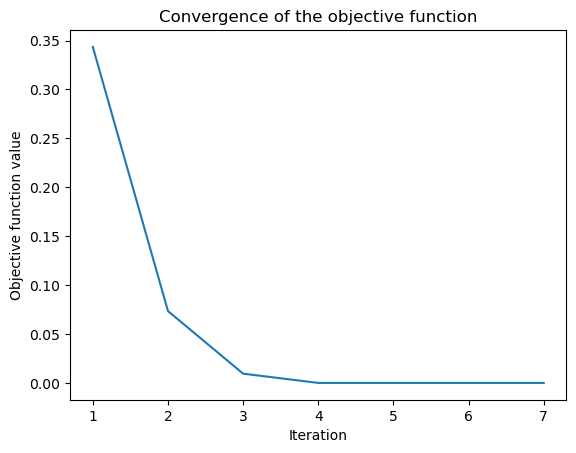

In [18]:
optimizer.plot_convergence()

ROSENBROCK FUNCTION

In [23]:
# Rosenbrock Function
optimizer = MultiVariableOptimizer(rosenbrock, 3, -2.048, 2.048)
optimal_solution = optimizer.optimize()

print(f"Optimal Solution: {np.round(optimal_solution, 2)}")
print(f"Optimal Value: {np.round(rosenbrock(optimal_solution),2)}")
print(f"Function Calls: {optimizer.function_call_counter}")

Optimal Solution: [1.   0.99 0.99]
Optimal Value: 0.0
Function Calls: 2133


In [24]:
print(optimizer.log())

--------------------------------------------------------------------------
INITIATING CONJUGATE GRADIENT METHOD
Initial guess: [0.57957915 0.57957915 0.57957915]
Initial gradient: [-57.33060338  -8.59717148  48.7334319 ]
Initial conjugate direction: [ 57.33060338   8.59717148 -48.7334319 ]
UNDIRECTIONAL SEARCH
Initial Lambda: 0.2830936590652341
Next position: [0.79388058 0.61171532 0.39741389]
--------------------------------------------------------------------------
Iteration 1 : 
 x = [0.79388058 0.61171532 0.39741389], 
 grad = [  5.47233906 -10.16396516   4.64365093] , 
 prev grad = [-57.33060338  -8.59717148  48.7334319 ], 
 conjugate direction = [ 57.33060338   8.59717148 -48.7334319 ]
Conjugate direction: [-3.92487814 10.396019   -5.95905801]
Lambda: 0.01552573699309434
Next position: [0.78904787 0.62451595 0.39007649]
Move to the next iteration
--------------------------------------------------------------------------
Iteration 2 : 
 x = [0.78904787 0.62451595 0.39007649], 
 gr

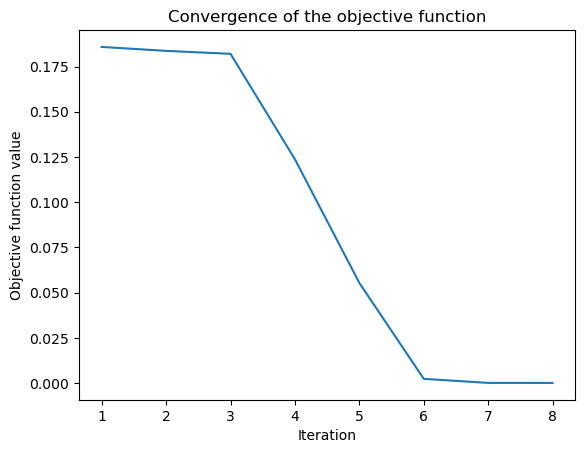

In [25]:
optimizer.plot_convergence()

DIXON PRICE FUNCTION

In [27]:
# Dixon Price Function
optimizer = MultiVariableOptimizer(dixon_price, 4, -10, 10)
optimal_solution = optimizer.optimize()
print(f"Optimal Solution: {np.round(optimal_solution, 2)}")
print(f"Optimal Value: {np.round(dixon_price(optimal_solution),2)}")
print(f"Function Calls: {optimizer.function_call_counter}")

Optimal Solution: [1.   0.71 0.59 0.55]
Optimal Value: 0.0
Function Calls: 1528


In [28]:
print(optimizer.log())

--------------------------------------------------------------------------
INITIATING CONJUGATE GRADIENT METHOD
Initial guess: [7.11802629 7.11802629 7.11802629 7.11802629]
Initial gradient: [ -364.62222779 10164.66116998 15341.20632568 21459.89718192]
Initial conjugate direction: [   364.62222779 -10164.66116998 -15341.20632568 -21459.89718192]
UNDIRECTIONAL SEARCH
Initial Lambda: 11.452157114467614
Next position: [ 7.26572154  3.00069029  0.90385938 -1.57460062]
--------------------------------------------------------------------------
Iteration 1 : 
 x = [ 7.26572154  3.00069029  0.90385938 -1.57460062], 
 grad = [ -30.43880835  523.962265    -62.08775727 -204.31387149] , 
 prev grad = [ -364.62222779 10164.66116998 15341.20632568 21459.89718192], 
 conjugate direction = [   364.62222779 -10164.66116998 -15341.20632568 -21459.89718192]
Conjugate direction: [  30.58526338 -528.04502693   55.92577193  195.69423825]
Lambda: 1.259452692159459
Next position: [ 7.33369079  1.82722249  1.0

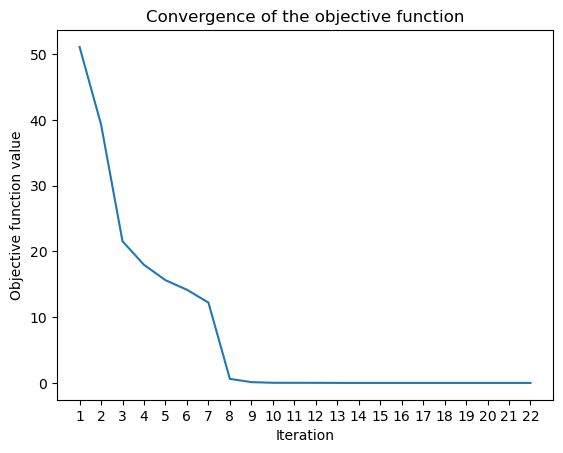

In [29]:
optimizer.plot_convergence()

TRID Function

In [30]:
optimizer = MultiVariableOptimizer(trid, 6, -36, 36)
optimal_solution = optimizer.optimize()
print(f"Optimal Solution: {np.round(optimal_solution, 2)}")
print(f"Optimal Value: {np.round(trid(optimal_solution),2)}")
print(f"Function Calls: {optimizer.function_call_counter}")

Optimal Solution: [ 6. 10. 12. 12. 10.  6.]
Optimal Value: -50.0
Function Calls: 277


In [31]:
print(optimizer.log())

--------------------------------------------------------------------------
INITIATING CONJUGATE GRADIENT METHOD
Initial guess: [-23.19900834 -23.19900834 -23.19900834 -23.19900834 -23.19900834
 -23.19900834]
Initial gradient: [-25.19900834  -2.00000002  -1.99999999  -1.99999999  -1.99999999
 -25.19900836]
Initial conjugate direction: [25.19900834  2.00000002  1.99999999  1.99999999  1.99999999 25.19900836]
UNDIRECTIONAL SEARCH
Initial Lambda: 19.658995236204458
Next position: [ -9.38474747 -22.10259527 -22.10259529 -22.10259529 -22.10259529
  -9.38474745]
--------------------------------------------------------------------------
Iteration 1 : 
 x = [ -9.38474747 -22.10259527 -22.10259529 -22.10259529 -22.10259529
  -9.38474745], 
 grad = [  1.33310034 -14.71784778  -2.00000002  -2.00000002 -14.71784785
   1.33310037] , 
 prev grad = [-25.19900834  -2.00000002  -1.99999999  -1.99999999  -1.99999999
 -25.19900836], 
 conjugate direction = [25.19900834  2.00000002  1.99999999  1.99999999 

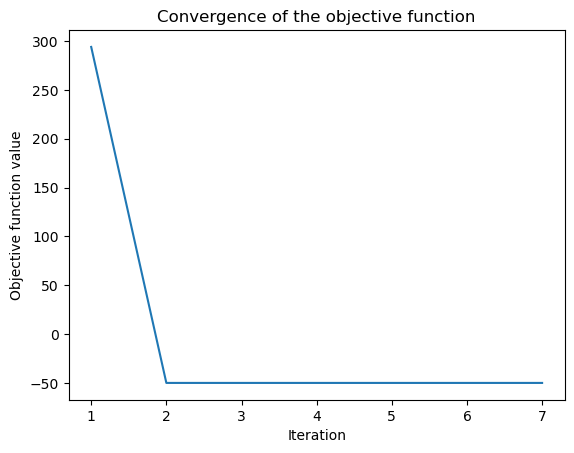

In [32]:
optimizer.plot_convergence()

ZAKHAROV FUNCTION

In [55]:
optimizer = MultiVariableOptimizer(zakharov_function, 2, -5, 10)
optimal_solution = optimizer.optimize()
print(f"Optimal Solution: {np.round(optimal_solution, 2)}")
print(f"Optimal Value: {np.round(zakharov_function(optimal_solution),2)}")
print(f"Function Calls: {optimizer.function_call_counter}")

Optimal Solution: [0. 0.]
Optimal Value: 0.0
Function Calls: 200


In [56]:
print(optimizer.log())

--------------------------------------------------------------------------
INITIATING CONJUGATE GRADIENT METHOD
Initial guess: [-1.36225288 -1.36225288]
Initial gradient: [-21.83173324 -40.93896073]
Initial conjugate direction: [21.83173324 40.93896073]
UNDIRECTIONAL SEARCH
Initial Lambda: 1.834841693463152
Next position: [-0.49887122  0.25676415]
--------------------------------------------------------------------------
Iteration 1 : 
 x = [-0.49887122  0.25676415], 
 grad = [-0.99041311  0.52818695] , 
 prev grad = [-21.83173324 -40.93896073], 
 conjugate direction = [21.83173324 40.93896073]
Conjugate direction: [ 1.00319091 -0.50422597]
Lambda: 0.5613637996640115
Next position: [0.00270065 0.00466302]
Move to the next iteration
--------------------------------------------------------------------------
Iteration 2 : 
 x = [0.00270065 0.00466302], 
 grad = [0.01141508 0.02135361] , 
 prev grad = [-0.99041311  0.52818695], 
 conjugate direction = [ 1.00319091 -0.50422597]
Conjugate di

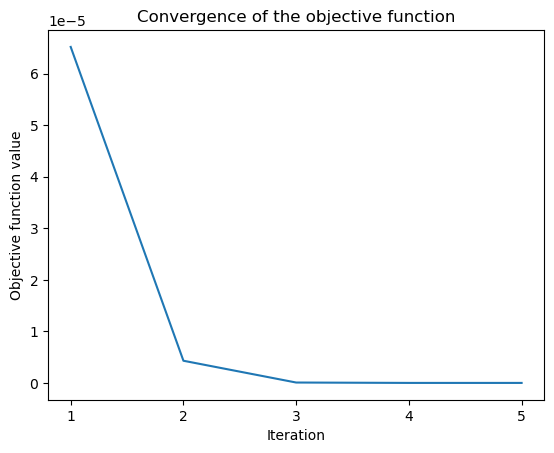

In [57]:
optimizer.plot_convergence()